In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, minmax_scale, scale
import matplotlib.pyplot as plt

In [2]:
data_path= "/home/21953404Victor/Deep/drive-download-20231121T165626Z-001/HotelReservationsPreparedCleanAttributes.csv"
label_path = "/home/21953404Victor/Deep/drive-download-20231121T165626Z-001/HotelReservationsOutput.csv"

In [3]:
features  = pd.read_csv(data_path)
labels = pd.read_csv(label_path)

In [4]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=42)

# Adicionalmente, divide el conjunto de entrenamiento para crear un conjunto de validación
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.1, random_state=42)  # Esto reserva el 20% del total de datos para validación

In [5]:
import tensorflow as tf

# Verificar dispositivos disponibles
print("Dispositivos disponibles: ", tf.config.experimental.list_physical_devices())

# Verificar si se detecta la GPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if not gpu_devices:
    print("No se detectó una GPU. Asegúrate de que el acelerador de hardware esté configurado en Colab.")
else:
    print("GPU disponible: ", gpu_devices)

2023-11-28 16:27:03.114238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 16:27:03.225715: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 16:27:03.740803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:/opt/hadoop/lib/native:
2023-11-28 16:27:03.740857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvin

Dispositivos disponibles:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No se detectó una GPU. Asegúrate de que el acelerador de hardware esté configurado en Colab.


2023-11-28 16:27:04.194463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-28 16:27:04.198857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:/opt/hadoop/lib/native:
2023-11-28 16:27:04.198869: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import optuna
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import SGD, RMSprop

from tensorflow.keras.initializers import GlorotUniform, HeNormal, RandomNormal
from tensorflow.keras.regularizers import l1, l2, l1_l2

from tensorflow.keras.layers import Activation, LeakyReLU

def build_model(trial):
    # Estructura de la red neuronal
    n_layers = trial.suggest_int('n_layers', 1, 100)
    model = models.Sequential()

    for i in range(n_layers):
        num_units = trial.suggest_categorical(f'n_units_l{i}', [16, 32, 64, 128, 256])
        activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh', 'elu', 'selu', 'leakyrelu'])

        # Inicialización de pesos
        init_strategy = trial.suggest_categorical(f'init_{i}', ['glorot_uniform', 'he_normal', 'random_normal'])
        initializer = {'glorot_uniform': GlorotUniform(), 'he_normal': HeNormal(), 'random_normal': RandomNormal()}[init_strategy]

        # Regularización
        reg_strategy = trial.suggest_categorical(f'reg_{i}', ['l1', 'l2', 'l1_l2'])
        l1_ratio = trial.suggest_float(f'l1_ratio_{i}', 1e-5, 1e-1, log=True)
        l2_ratio = trial.suggest_float(f'l2_ratio_{i}', 1e-5, 1e-1, log=True)
        regularizer = {'l1': l1(l1_ratio), 'l2': l2(l2_ratio), 'l1_l2': l1_l2(l1=l1_ratio, l2=l2_ratio)}[reg_strategy]

        if i == 0:
            model.add(Dense(num_units, input_shape=(input_shape,), kernel_initializer=initializer, kernel_regularizer=regularizer))
        else:
            model.add(Dense(num_units, kernel_initializer=initializer, kernel_regularizer=regularizer))

        if activation == 'leakyrelu':
            # Optar por una capa avanzada de LeakyReLU
            alpha = trial.suggest_float(f'leakyrelu_alpha_l{i}', 0.01, 0.3)
            model.add(LeakyReLU(alpha=alpha))
        else:
            # Para otras activaciones, se puede utilizar directamente en la capa densa
            model.add(Activation(activation))

        # Batch Normalization
        if trial.suggest_categorical(f'batch_norm_l{i}', [True, False]):
            model.add(BatchNormalization())

        # Dropout
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    # Optimizador
    optimizer_choice = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    if optimizer_choice == 'adam':
        beta_1 = trial.suggest_float('beta1', 0.85, 0.99)
        beta_2 = trial.suggest_float('beta2', 0.9, 0.999)
        epsilon = trial.suggest_float('epsilon', 1e-8, 1e-7, log=True)
        optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    elif optimizer_choice == 'sgd':
        # Solo sugiere 'momentum' si el optimizador elegido es SGD
        momentum = trial.suggest_float('momentum', 0.1, 0.99)  # Ajusta el rango si es necesario
        optimizer = SGD(learning_rate=lr, momentum=momentum)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import gc

def objective(trial):
    # Verificar y configurar el uso de la GPU
    if tf.config.experimental.list_physical_devices('GPU'):
        print("Usando GPU para el Trial", trial.number)
    else:
        print("GPU no disponible, usando CPU para el Trial", trial.number)

    model = build_model(trial)

    # Parametrización del número de épocas y tamaño del batch
    epochs = trial.suggest_int('epochs', 10, 500)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    

    # Configuración de Early Stopping
    early_stopping_patience = trial.suggest_int('early_stopping_patience', 3, 20)
    early_stopping_min_delta = trial.suggest_float('early_stopping_min_delta', 0.0001, 0.01)
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, min_delta=early_stopping_min_delta, verbose=1)

    # Configuración del Learning Rate Scheduler
    factor = trial.suggest_float("lr_reduce_factor", 0.1, 0.9)
    lr_patience = trial.suggest_int("lr_reduce_patience", 5, 20)
    min_lr = trial.suggest_float("min_lr", 1e-6, 1e-4, log=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=lr_patience, min_lr=min_lr, verbose=1)

    # Entrenamiento del modelo
    print(f"Entrenando Trial {trial.number}...")
    history = model.fit(features_train, labels_train,
                        validation_data=(features_val, labels_val),
                        epochs=epochs, batch_size=batch_size,
                        verbose=1,
                        callbacks=[early_stopping, lr_scheduler])

    # Evaluar la pérdida en el conjunto de validación
    loss, _ = model.evaluate(features_val, labels_val, verbose=0)
    print(f"Trial {trial.number} completado. Pérdida en validación: {loss}")

    # Limpiar la memoria después de cada trial
    del model, history
    tf.keras.backend.clear_session()
    gc.collect()

    # Devolver la pérdida en lugar de la precisión
    return loss



In [8]:
input_shape = features_train.shape[1]  # Número de variables explicativas

In [9]:
import optuna

storage = "sqlite:///example.db"  # Ruta de la base de datos SQLite
study_name = "my_study"  # Nombre del estudio

# Crear un nuevo estudio o cargar uno existente
study = optuna.create_study(study_name=study_name, direction='minimize', storage=storage, load_if_exists=True)


[I 2023-11-28 16:27:04,572] Using an existing study with name 'my_study' instead of creating a new one.


In [10]:
# Número de ensayos en el estudio
num_trials = len(study.trials)
print(f"El estudio contiene {num_trials} ensayos.")

El estudio contiene 4815 ensayos.


In [11]:
trials_restantes=50000-num_trials
study.optimize(objective, n_trials=trials_restantes)

GPU no disponible, usando CPU para el Trial 4815


2023-11-28 16:27:15.644134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[W 2023-11-28 16:27:42,411] Trial 4815 failed with parameters: {'n_layers': 86, 'n_units_l0': 32, 'activation_l0': 'tanh', 'init_0': 'he_normal', 'reg_0': 'l1', 'l1_ratio_0': 0.005586540709720485, 'l2_ratio_0': 0.05335667857689035, 'batch_norm_l0': True, 'dropout_l0': 0.00893735100217333, 'n_units_l1': 64, 'activation_l1': 'relu', 'init_1': 'he_normal', 'reg_1': 'l1', 'l1_ratio_1': 1.1905947111756107e-05, 'l2_ratio_1': 0.002387961772736297, 'batch_norm_l1': True, 'dropout_l1': 0.1187330837807745, 'n_units_l2': 256, 'activation_l2': 'leakyrelu', 'init_2': 'glorot_uniform', 'reg_2': 'l2', 'l1_ratio_2': 0.0002254809130653277, 'l2_ratio_2': 0.00041722815

[W 2023-11-28 16:27:42,412] Trial 4815 failed with value None.


KeyboardInterrupt: 

In [12]:
print('Número de pruebas finalizadas:', len(study.trials))
print('Mejor prueba:', study.best_trial.params)

Número de pruebas finalizadas: 4816
Mejor prueba: {'activation_l0': 'relu', 'activation_l1': 'relu', 'activation_l2': 'leakyrelu', 'batch_norm_l0': True, 'batch_norm_l1': True, 'batch_norm_l2': True, 'batch_size': 256, 'beta1': 0.9410592319173001, 'beta2': 0.9899472085336848, 'dropout_l0': 0.01997342639207237, 'dropout_l1': 0.08417760523519362, 'dropout_l2': 0.17035421142983795, 'early_stopping_min_delta': 0.009754198149048772, 'early_stopping_patience': 20, 'epochs': 91, 'epsilon': 2.01405157352742e-08, 'init_0': 'random_normal', 'init_1': 'he_normal', 'init_2': 'glorot_uniform', 'l1_ratio_0': 3.07139760732974e-05, 'l1_ratio_1': 2.337213486465786e-05, 'l1_ratio_2': 0.0006901481134461482, 'l2_ratio_0': 8.037669345325199e-05, 'l2_ratio_1': 0.001667473031604875, 'l2_ratio_2': 2.209449383472944e-05, 'leakyrelu_alpha_l2': 0.0839771414030093, 'lr': 0.004599934430456682, 'n_layers': 3, 'n_units_l0': 32, 'n_units_l1': 64, 'n_units_l2': 256, 'optimizer': 'adam', 'reg_0': 'l1', 'reg_1': 'l1', '

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Utiliza los mejores hiperparámetros encontrados por Optuna
best_params = study.best_trial.params
model = build_model(optuna.trial.FixedTrial(best_params))

# Los valores de 'epochs' y 'batch_size' se toman de los mejores hiperparámetros
epochs = best_params.get("epochs")  # Valor por defecto si no se optimizó
epochs=2000
batch_size = best_params.get("batch_size")  # Valor por defecto si no se optimizó

# Entrenar el modelo final
history = model.fit(features_train, labels_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1)  # 10% de los datos de entrenamiento para validación


Epoch 1/2000
87/87 [==============================] - 1s 6ms/step - loss: 0.4946 - accuracy: 0.7746 - val_loss: 0.6446 - val_accuracy: 0.6477
Epoch 2/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.4196 - accuracy: 0.8130 - val_loss: 0.5802 - val_accuracy: 0.6520
Epoch 3/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.4102 - accuracy: 0.8172 - val_loss: 0.5053 - val_accuracy: 0.7450
Epoch 4/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.4002 - accuracy: 0.8225 - val_loss: 0.5043 - val_accuracy: 0.7717
Epoch 5/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.4024 - accuracy: 0.8232 - val_loss: 0.4955 - val_accuracy: 0.7709
Epoch 6/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3888 - accuracy: 0.8309 - val_loss: 0.4848 - val_accuracy: 0.7571
Epoch 7/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3897 - accuracy: 0.8286 - val_loss: 0.3863 - val_accuracy: 0.8260
Epoch 

87/87 [==============================] - 0s 4ms/step - loss: 0.3155 - accuracy: 0.8681 - val_loss: 0.3316 - val_accuracy: 0.8639
Epoch 116/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3132 - accuracy: 0.8664 - val_loss: 0.3250 - val_accuracy: 0.8725
Epoch 117/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3157 - accuracy: 0.8675 - val_loss: 0.3267 - val_accuracy: 0.8699
Epoch 118/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3141 - accuracy: 0.8689 - val_loss: 0.3405 - val_accuracy: 0.8519
Epoch 119/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3134 - accuracy: 0.8687 - val_loss: 0.3299 - val_accuracy: 0.8734
Epoch 120/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3141 - accuracy: 0.8684 - val_loss: 0.3351 - val_accuracy: 0.8674
Epoch 121/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3114 - accuracy: 0.8728 - val_loss: 0.3332 - val_accuracy: 0.8708
Epoch 1

Epoch 172/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3072 - accuracy: 0.8708 - val_loss: 0.3373 - val_accuracy: 0.8596
Epoch 173/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3043 - accuracy: 0.8726 - val_loss: 0.3808 - val_accuracy: 0.8544
Epoch 174/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3087 - accuracy: 0.8722 - val_loss: 0.3240 - val_accuracy: 0.8699
Epoch 175/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3045 - accuracy: 0.8747 - val_loss: 0.3356 - val_accuracy: 0.8656
Epoch 176/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3071 - accuracy: 0.8723 - val_loss: 0.3293 - val_accuracy: 0.8734
Epoch 177/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3035 - accuracy: 0.8728 - val_loss: 0.3169 - val_accuracy: 0.8734
Epoch 178/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3085 - accuracy: 0.8721 - val_loss: 0.3295 - val_accuracy:

Epoch 229/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3032 - accuracy: 0.8761 - val_loss: 0.3382 - val_accuracy: 0.8630
Epoch 230/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3038 - accuracy: 0.8757 - val_loss: 0.3317 - val_accuracy: 0.8639
Epoch 231/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3019 - accuracy: 0.8755 - val_loss: 0.3365 - val_accuracy: 0.8648
Epoch 232/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3027 - accuracy: 0.8762 - val_loss: 0.3404 - val_accuracy: 0.8579
Epoch 233/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3018 - accuracy: 0.8755 - val_loss: 0.3259 - val_accuracy: 0.8768
Epoch 234/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3066 - accuracy: 0.8709 - val_loss: 0.3241 - val_accuracy: 0.8717
Epoch 235/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3011 - accuracy: 0.8755 - val_loss: 0.3297 - val_accuracy:

Epoch 286/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2984 - accuracy: 0.8783 - val_loss: 0.3416 - val_accuracy: 0.8674
Epoch 287/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2995 - accuracy: 0.8743 - val_loss: 0.3410 - val_accuracy: 0.8665
Epoch 288/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3023 - accuracy: 0.8757 - val_loss: 0.3706 - val_accuracy: 0.8553
Epoch 289/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2992 - accuracy: 0.8776 - val_loss: 0.3276 - val_accuracy: 0.8699
Epoch 290/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3004 - accuracy: 0.8778 - val_loss: 0.3364 - val_accuracy: 0.8674
Epoch 291/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3016 - accuracy: 0.8764 - val_loss: 0.3331 - val_accuracy: 0.8648
Epoch 292/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2989 - accuracy: 0.8757 - val_loss: 0.3372 - val_accuracy:

Epoch 343/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2949 - accuracy: 0.8794 - val_loss: 0.3330 - val_accuracy: 0.8708
Epoch 344/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2996 - accuracy: 0.8758 - val_loss: 0.3296 - val_accuracy: 0.8794
Epoch 345/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2975 - accuracy: 0.8784 - val_loss: 0.3159 - val_accuracy: 0.8725
Epoch 346/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2968 - accuracy: 0.8788 - val_loss: 0.3435 - val_accuracy: 0.8613
Epoch 347/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2952 - accuracy: 0.8786 - val_loss: 0.3328 - val_accuracy: 0.8734
Epoch 348/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2978 - accuracy: 0.8775 - val_loss: 0.3339 - val_accuracy: 0.8570
Epoch 349/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3008 - accuracy: 0.8786 - val_loss: 0.3634 - val_accuracy:

Epoch 400/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2927 - accuracy: 0.8819 - val_loss: 0.3219 - val_accuracy: 0.8717
Epoch 401/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2956 - accuracy: 0.8800 - val_loss: 0.3367 - val_accuracy: 0.8622
Epoch 402/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2963 - accuracy: 0.8806 - val_loss: 0.3174 - val_accuracy: 0.8829
Epoch 403/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3000 - accuracy: 0.8778 - val_loss: 0.3238 - val_accuracy: 0.8811
Epoch 404/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2964 - accuracy: 0.8794 - val_loss: 0.3255 - val_accuracy: 0.8674
Epoch 405/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2963 - accuracy: 0.8783 - val_loss: 0.3278 - val_accuracy: 0.8708
Epoch 406/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2956 - accuracy: 0.8807 - val_loss: 0.3240 - val_accuracy:

Epoch 457/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2930 - accuracy: 0.8811 - val_loss: 0.3384 - val_accuracy: 0.8665
Epoch 458/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2951 - accuracy: 0.8792 - val_loss: 0.3369 - val_accuracy: 0.8725
Epoch 459/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.3007 - accuracy: 0.8762 - val_loss: 0.3310 - val_accuracy: 0.8751
Epoch 460/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2996 - accuracy: 0.8775 - val_loss: 0.3391 - val_accuracy: 0.8587
Epoch 461/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2939 - accuracy: 0.8831 - val_loss: 0.3509 - val_accuracy: 0.8613
Epoch 462/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2944 - accuracy: 0.8811 - val_loss: 0.3295 - val_accuracy: 0.8717
Epoch 463/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2937 - accuracy: 0.8811 - val_loss: 0.3271 - val_accuracy:

Epoch 514/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2962 - accuracy: 0.8823 - val_loss: 0.3423 - val_accuracy: 0.8544
Epoch 515/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2980 - accuracy: 0.8796 - val_loss: 0.3178 - val_accuracy: 0.8786
Epoch 516/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2929 - accuracy: 0.8824 - val_loss: 0.3438 - val_accuracy: 0.8665
Epoch 517/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2904 - accuracy: 0.8824 - val_loss: 0.3357 - val_accuracy: 0.8777
Epoch 518/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2919 - accuracy: 0.8816 - val_loss: 0.3361 - val_accuracy: 0.8630
Epoch 519/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2963 - accuracy: 0.8805 - val_loss: 0.3324 - val_accuracy: 0.8674
Epoch 520/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2894 - accuracy: 0.8804 - val_loss: 0.3335 - val_accuracy:

Epoch 571/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2930 - accuracy: 0.8822 - val_loss: 0.3249 - val_accuracy: 0.8786
Epoch 572/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2927 - accuracy: 0.8811 - val_loss: 0.3457 - val_accuracy: 0.8587
Epoch 573/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2917 - accuracy: 0.8823 - val_loss: 0.3262 - val_accuracy: 0.8751
Epoch 574/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2921 - accuracy: 0.8827 - val_loss: 0.3246 - val_accuracy: 0.8803
Epoch 575/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2954 - accuracy: 0.8802 - val_loss: 0.3328 - val_accuracy: 0.8682
Epoch 576/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2919 - accuracy: 0.8822 - val_loss: 0.3409 - val_accuracy: 0.8742
Epoch 577/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2914 - accuracy: 0.8811 - val_loss: 0.3269 - val_accuracy:

Epoch 628/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2909 - accuracy: 0.8801 - val_loss: 0.3174 - val_accuracy: 0.8734
Epoch 629/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2898 - accuracy: 0.8829 - val_loss: 0.3310 - val_accuracy: 0.8691
Epoch 630/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2896 - accuracy: 0.8804 - val_loss: 0.3416 - val_accuracy: 0.8691
Epoch 631/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2907 - accuracy: 0.8816 - val_loss: 0.3319 - val_accuracy: 0.8648
Epoch 632/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2861 - accuracy: 0.8852 - val_loss: 0.3258 - val_accuracy: 0.8742
Epoch 633/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2917 - accuracy: 0.8833 - val_loss: 0.3295 - val_accuracy: 0.8725
Epoch 634/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2940 - accuracy: 0.8828 - val_loss: 0.3460 - val_accuracy:

Epoch 685/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2932 - accuracy: 0.8818 - val_loss: 0.3282 - val_accuracy: 0.8639
Epoch 686/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2919 - accuracy: 0.8819 - val_loss: 0.3361 - val_accuracy: 0.8682
Epoch 687/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2920 - accuracy: 0.8816 - val_loss: 0.3268 - val_accuracy: 0.8699
Epoch 688/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2954 - accuracy: 0.8822 - val_loss: 0.3534 - val_accuracy: 0.8691
Epoch 689/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2927 - accuracy: 0.8830 - val_loss: 0.3237 - val_accuracy: 0.8760
Epoch 690/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2968 - accuracy: 0.8795 - val_loss: 0.3328 - val_accuracy: 0.8717
Epoch 691/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2925 - accuracy: 0.8829 - val_loss: 0.3267 - val_accuracy:

Epoch 742/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2933 - accuracy: 0.8810 - val_loss: 0.3302 - val_accuracy: 0.8699
Epoch 743/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2891 - accuracy: 0.8855 - val_loss: 0.3378 - val_accuracy: 0.8682
Epoch 744/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2948 - accuracy: 0.8819 - val_loss: 0.3268 - val_accuracy: 0.8725
Epoch 745/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2918 - accuracy: 0.8820 - val_loss: 0.3400 - val_accuracy: 0.8682
Epoch 746/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2920 - accuracy: 0.8818 - val_loss: 0.3277 - val_accuracy: 0.8742
Epoch 747/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2864 - accuracy: 0.8847 - val_loss: 0.3257 - val_accuracy: 0.8682
Epoch 748/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2908 - accuracy: 0.8828 - val_loss: 0.3324 - val_accuracy:

Epoch 799/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2900 - accuracy: 0.8838 - val_loss: 0.3514 - val_accuracy: 0.8553
Epoch 800/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2916 - accuracy: 0.8816 - val_loss: 0.3379 - val_accuracy: 0.8742
Epoch 801/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2951 - accuracy: 0.8803 - val_loss: 0.3252 - val_accuracy: 0.8760
Epoch 802/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2925 - accuracy: 0.8817 - val_loss: 0.3357 - val_accuracy: 0.8665
Epoch 803/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2892 - accuracy: 0.8835 - val_loss: 0.3468 - val_accuracy: 0.8622
Epoch 804/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2941 - accuracy: 0.8818 - val_loss: 0.3235 - val_accuracy: 0.8794
Epoch 805/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2935 - accuracy: 0.8837 - val_loss: 0.3342 - val_accuracy:

Epoch 856/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2897 - accuracy: 0.8842 - val_loss: 0.3340 - val_accuracy: 0.8708
Epoch 857/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2914 - accuracy: 0.8822 - val_loss: 0.3358 - val_accuracy: 0.8630
Epoch 858/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2874 - accuracy: 0.8825 - val_loss: 0.3517 - val_accuracy: 0.8579
Epoch 859/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2889 - accuracy: 0.8839 - val_loss: 0.3401 - val_accuracy: 0.8691
Epoch 860/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2935 - accuracy: 0.8822 - val_loss: 0.3476 - val_accuracy: 0.8708
Epoch 861/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2896 - accuracy: 0.8810 - val_loss: 0.3401 - val_accuracy: 0.8742
Epoch 862/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2947 - accuracy: 0.8808 - val_loss: 0.3473 - val_accuracy:

Epoch 913/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2880 - accuracy: 0.8844 - val_loss: 0.3369 - val_accuracy: 0.8760
Epoch 914/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2909 - accuracy: 0.8828 - val_loss: 0.3337 - val_accuracy: 0.8717
Epoch 915/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2946 - accuracy: 0.8792 - val_loss: 0.3471 - val_accuracy: 0.8811
Epoch 916/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2900 - accuracy: 0.8823 - val_loss: 0.3277 - val_accuracy: 0.8760
Epoch 917/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2924 - accuracy: 0.8824 - val_loss: 0.3207 - val_accuracy: 0.8725
Epoch 918/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2884 - accuracy: 0.8830 - val_loss: 0.3285 - val_accuracy: 0.8630
Epoch 919/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2899 - accuracy: 0.8834 - val_loss: 0.3386 - val_accuracy:

Epoch 970/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2917 - accuracy: 0.8838 - val_loss: 0.3287 - val_accuracy: 0.8691
Epoch 971/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2879 - accuracy: 0.8827 - val_loss: 0.3593 - val_accuracy: 0.8536
Epoch 972/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2902 - accuracy: 0.8835 - val_loss: 0.3379 - val_accuracy: 0.8665
Epoch 973/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2921 - accuracy: 0.8812 - val_loss: 0.3382 - val_accuracy: 0.8691
Epoch 974/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2914 - accuracy: 0.8851 - val_loss: 0.3427 - val_accuracy: 0.8648
Epoch 975/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2913 - accuracy: 0.8830 - val_loss: 0.3379 - val_accuracy: 0.8596
Epoch 976/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2869 - accuracy: 0.8838 - val_loss: 0.3295 - val_accuracy:

Epoch 1027/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2884 - accuracy: 0.8832 - val_loss: 0.3321 - val_accuracy: 0.8691
Epoch 1028/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2910 - accuracy: 0.8845 - val_loss: 0.3249 - val_accuracy: 0.8708
Epoch 1029/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2879 - accuracy: 0.8856 - val_loss: 0.3327 - val_accuracy: 0.8682
Epoch 1030/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2882 - accuracy: 0.8854 - val_loss: 0.3280 - val_accuracy: 0.8717
Epoch 1031/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2885 - accuracy: 0.8826 - val_loss: 0.3231 - val_accuracy: 0.8742
Epoch 1032/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2903 - accuracy: 0.8830 - val_loss: 0.3339 - val_accuracy: 0.8734
Epoch 1033/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2906 - accuracy: 0.8838 - val_loss: 0.3250 - val_ac

87/87 [==============================] - 0s 4ms/step - loss: 0.2870 - accuracy: 0.8857 - val_loss: 0.3243 - val_accuracy: 0.8682
Epoch 1140/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2909 - accuracy: 0.8843 - val_loss: 0.3223 - val_accuracy: 0.8803
Epoch 1141/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2912 - accuracy: 0.8844 - val_loss: 0.3287 - val_accuracy: 0.8794
Epoch 1142/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2870 - accuracy: 0.8860 - val_loss: 0.3379 - val_accuracy: 0.8639
Epoch 1143/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2873 - accuracy: 0.8858 - val_loss: 0.3306 - val_accuracy: 0.8725
Epoch 1144/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2922 - accuracy: 0.8820 - val_loss: 0.3333 - val_accuracy: 0.8751
Epoch 1145/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2846 - accuracy: 0.8869 - val_loss: 0.3244 - val_accuracy: 0.8751
E

87/87 [==============================] - 0s 4ms/step - loss: 0.2919 - accuracy: 0.8848 - val_loss: 0.3367 - val_accuracy: 0.8742
Epoch 1252/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2860 - accuracy: 0.8863 - val_loss: 0.3271 - val_accuracy: 0.8708
Epoch 1253/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2866 - accuracy: 0.8856 - val_loss: 0.3272 - val_accuracy: 0.8656
Epoch 1254/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2878 - accuracy: 0.8849 - val_loss: 0.3251 - val_accuracy: 0.8760
Epoch 1255/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2886 - accuracy: 0.8862 - val_loss: 0.3178 - val_accuracy: 0.8768
Epoch 1256/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2811 - accuracy: 0.8910 - val_loss: 0.3285 - val_accuracy: 0.8725
Epoch 1257/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2888 - accuracy: 0.8843 - val_loss: 0.3352 - val_accuracy: 0.8751
E

87/87 [==============================] - 0s 4ms/step - loss: 0.2870 - accuracy: 0.8847 - val_loss: 0.3321 - val_accuracy: 0.8786
Epoch 1364/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2911 - accuracy: 0.8836 - val_loss: 0.3232 - val_accuracy: 0.8725
Epoch 1365/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2903 - accuracy: 0.8848 - val_loss: 0.3347 - val_accuracy: 0.8751
Epoch 1366/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2851 - accuracy: 0.8876 - val_loss: 0.3323 - val_accuracy: 0.8751
Epoch 1367/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2885 - accuracy: 0.8844 - val_loss: 0.3196 - val_accuracy: 0.8742
Epoch 1368/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2851 - accuracy: 0.8851 - val_loss: 0.3579 - val_accuracy: 0.8699
Epoch 1369/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2886 - accuracy: 0.8851 - val_loss: 0.3219 - val_accuracy: 0.8725
E

87/87 [==============================] - 0s 4ms/step - loss: 0.2887 - accuracy: 0.8834 - val_loss: 0.3451 - val_accuracy: 0.8605
Epoch 1476/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2874 - accuracy: 0.8846 - val_loss: 0.3481 - val_accuracy: 0.8648
Epoch 1477/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2818 - accuracy: 0.8870 - val_loss: 0.3258 - val_accuracy: 0.8708
Epoch 1478/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2916 - accuracy: 0.8818 - val_loss: 0.3207 - val_accuracy: 0.8846
Epoch 1479/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2816 - accuracy: 0.8883 - val_loss: 0.3281 - val_accuracy: 0.8708
Epoch 1480/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2894 - accuracy: 0.8841 - val_loss: 0.3275 - val_accuracy: 0.8717
Epoch 1481/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2828 - accuracy: 0.8894 - val_loss: 0.3366 - val_accuracy: 0.8760
E

87/87 [==============================] - 0s 4ms/step - loss: 0.2871 - accuracy: 0.8852 - val_loss: 0.3211 - val_accuracy: 0.8734
Epoch 1588/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2816 - accuracy: 0.8878 - val_loss: 0.3305 - val_accuracy: 0.8751
Epoch 1589/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2870 - accuracy: 0.8862 - val_loss: 0.3241 - val_accuracy: 0.8760
Epoch 1590/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2850 - accuracy: 0.8874 - val_loss: 0.3274 - val_accuracy: 0.8682
Epoch 1591/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2912 - accuracy: 0.8842 - val_loss: 0.3196 - val_accuracy: 0.8682
Epoch 1592/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2876 - accuracy: 0.8852 - val_loss: 0.3298 - val_accuracy: 0.8699
Epoch 1593/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2882 - accuracy: 0.8849 - val_loss: 0.3330 - val_accuracy: 0.8699
E

87/87 [==============================] - 0s 4ms/step - loss: 0.2808 - accuracy: 0.8874 - val_loss: 0.3260 - val_accuracy: 0.8725
Epoch 1700/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2862 - accuracy: 0.8859 - val_loss: 0.3329 - val_accuracy: 0.8786
Epoch 1701/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2840 - accuracy: 0.8864 - val_loss: 0.3373 - val_accuracy: 0.8777
Epoch 1702/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2897 - accuracy: 0.8842 - val_loss: 0.3370 - val_accuracy: 0.8725
Epoch 1703/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2841 - accuracy: 0.8865 - val_loss: 0.3360 - val_accuracy: 0.8742
Epoch 1704/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2851 - accuracy: 0.8852 - val_loss: 0.3268 - val_accuracy: 0.8613
Epoch 1705/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2936 - accuracy: 0.8835 - val_loss: 0.3374 - val_accuracy: 0.8605
E

87/87 [==============================] - 0s 4ms/step - loss: 0.2888 - accuracy: 0.8853 - val_loss: 0.3363 - val_accuracy: 0.8691
Epoch 1812/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2854 - accuracy: 0.8853 - val_loss: 0.3239 - val_accuracy: 0.8708
Epoch 1813/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2869 - accuracy: 0.8854 - val_loss: 0.3427 - val_accuracy: 0.8648
Epoch 1814/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2844 - accuracy: 0.8863 - val_loss: 0.3267 - val_accuracy: 0.8760
Epoch 1815/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2837 - accuracy: 0.8870 - val_loss: 0.3329 - val_accuracy: 0.8639
Epoch 1816/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2832 - accuracy: 0.8866 - val_loss: 0.3402 - val_accuracy: 0.8717
Epoch 1817/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2844 - accuracy: 0.8866 - val_loss: 0.3339 - val_accuracy: 0.8691
E

87/87 [==============================] - 0s 4ms/step - loss: 0.2817 - accuracy: 0.8873 - val_loss: 0.3403 - val_accuracy: 0.8630
Epoch 1924/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2858 - accuracy: 0.8873 - val_loss: 0.3403 - val_accuracy: 0.8596
Epoch 1925/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2885 - accuracy: 0.8832 - val_loss: 0.3344 - val_accuracy: 0.8717
Epoch 1926/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2805 - accuracy: 0.8873 - val_loss: 0.3448 - val_accuracy: 0.8682
Epoch 1927/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2908 - accuracy: 0.8842 - val_loss: 0.3367 - val_accuracy: 0.8760
Epoch 1928/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2879 - accuracy: 0.8863 - val_loss: 0.3229 - val_accuracy: 0.8734
Epoch 1929/2000
87/87 [==============================] - 0s 4ms/step - loss: 0.2876 - accuracy: 0.8871 - val_loss: 0.3290 - val_accuracy: 0.8734
E

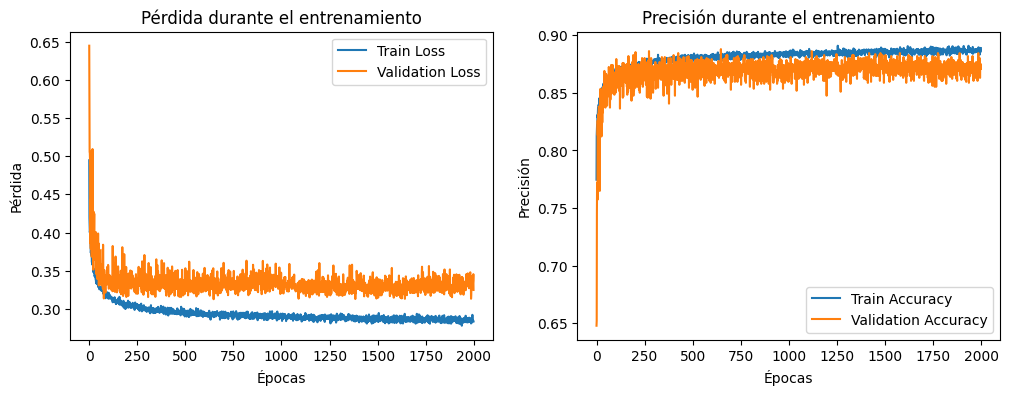

In [14]:
# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [15]:
# Evaluar el modelo en el conjunto de prueba
model.evaluate(features_test, labels_test)

227/227 [==============================] - 0s 618us/step - loss: 0.3207 - accuracy: 0.8730


[0.3207281827926636, 0.8730355501174927]

227/227 [==============================] - 0s 524us/step


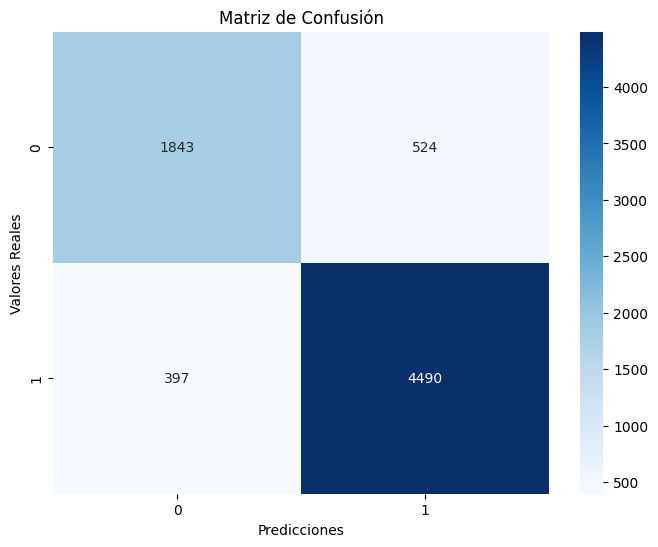

Accuracy: 0.8730355665839536
Recall: 0.9187640679353386
Precision: 0.895492620662146
F1 Score: 0.9069790930209068


In [16]:
# Generar y redondear las predicciones
predictions = model.predict(features_test)
predictions = np.round(predictions).astype(int)

# Calcular y visualizar la matriz de confusión
conf_matrix = confusion_matrix(labels_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

# Calcular y mostrar otras métricas
accuracy = accuracy_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)
f1 = f1_score(labels_test, predictions)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
